In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util

In [2]:
RAM_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-ref.paf"
RAM_MINHASH_REF_MAPPING = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-minhash-ref.paf"
RAM_MINHASH_AI_STRICT_LARGE_REF_MAPPING = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-minhash-ai-strict-large-ref.paf"
RAM_AI_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-ai-ref.paf"
RAM_AI_STRICT_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-ai-strict-ref.paf"
RAM_AI_STRICT_LARGE_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-ai-strict-large-ref.paf"
MINIMAP2_REF_MAPPIGN = "/storage2/tbrekalo/HG002-simulated/chr19-ovlps-minimap2-ref.paf"
READ_ORIGINS = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"

In [3]:
df_origins = util.load_origins_df(READ_ORIGINS)

In [4]:
def load_and_annote_overlaps(path: str) -> pl.DataFrame:
    return (
        util.load_paf_df(path)
        .join(
            df_origins.select(
                pl.col("query-name"),
                pl.col("origin-strand").alias("origin-strand"),
                pl.col("origin-start").alias("origin-start"),
                pl.col("origin-end").alias("origin-end"),
            ),
            on="query-name",
        )
        .with_columns(
            (
                pl.max_horizontal(
                    pl.min_horizontal(
                        pl.col("origin-end"),
                        pl.col("target-end"),
                    )
                    - pl.max_horizontal(
                        pl.col("origin-start"),
                        pl.col("target-start"),
                    ),
                    pl.lit(0),
                )
                / pl.max_horizontal(
                    pl.col("origin-end") - pl.col("origin-start"),
                    pl.col("target-end") - pl.col("target-start"),
                )
            ).alias("ratio")
        )
        .with_columns(
            (
                (pl.col("ratio") > 0.875)
                & (pl.col("strand") == pl.col("origin-strand"))
            ).alias("label")
        )
    )

In [5]:
df_ram = load_and_annote_overlaps(RAM_REF_MAPPIGN)
df_ram_minhash = load_and_annote_overlaps(RAM_MINHASH_REF_MAPPING)
df_ram_ai = load_and_annote_overlaps(RAM_AI_REF_MAPPIGN)
df_ram_ai_strict = load_and_annote_overlaps(RAM_AI_STRICT_REF_MAPPIGN)
df_ram_ai_strict_large = load_and_annote_overlaps(RAM_AI_STRICT_LARGE_REF_MAPPIGN)
df_ram_minhash_ai_strict_large = load_and_annote_overlaps(RAM_MINHASH_AI_STRICT_LARGE_REF_MAPPING)
df_minimap2 = load_and_annote_overlaps(MINIMAP2_REF_MAPPIGN)

In [6]:
def flatten_stats(df, name):
    return df["label"].value_counts().with_columns(pl.lit(name).alias("mapper"))

In [12]:
df_stats = pl.concat([
    flatten_stats(df_ram, "ram"),
    flatten_stats(df_ram_ai, "ram-ai"),
    flatten_stats(df_ram_ai_strict, "ram-ai-strict"),
    flatten_stats(df_ram_ai_strict_large, "ram-ai-strict-large"),
    flatten_stats(df_ram_minhash, "ram-minhash"),
    flatten_stats(df_ram_minhash_ai_strict_large, "ram-minhash-ai-strict-large"),
    flatten_stats(df_minimap2, "minimap2"),
])

<Axes: title={'center': 'true positive counts'}, xlabel='label', ylabel='count'>

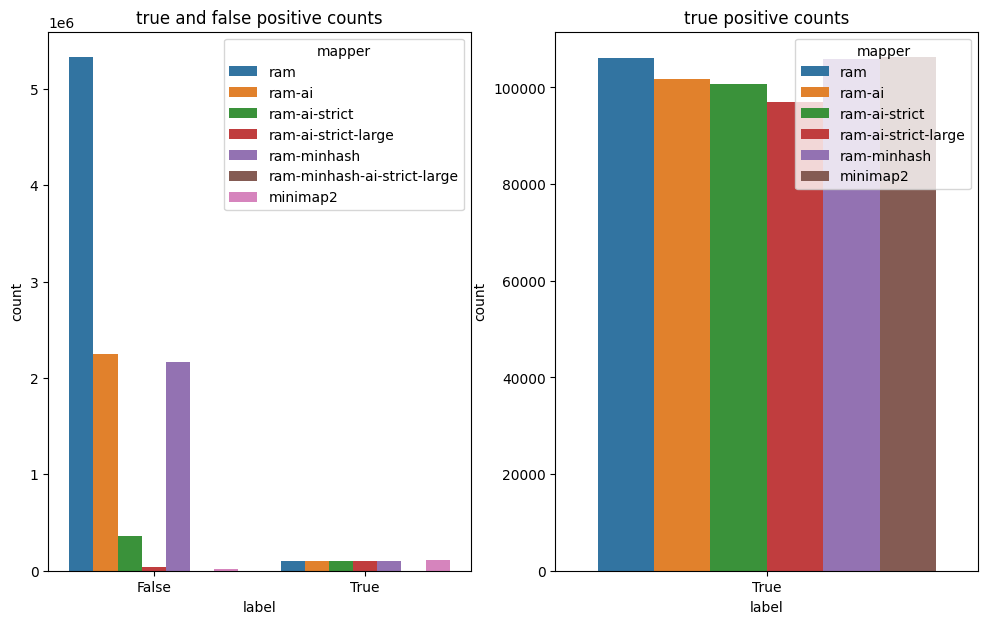

In [13]:
_, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].set_title("true and false positive counts")
sns.barplot(df_stats.to_pandas(), x="label", y="count", hue="mapper", ax=ax[0])

ax[1].set_title("true positive counts")
sns.barplot(df_stats.filter(pl.col("label")).to_pandas(), x="label", y="count", hue="mapper", ax=ax[1])